## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
import pickle
import pandas as pd

from plots import scientific_format, dmu_idm_dr, plot_observations, plot_varied_recoupling
from data_generation.variables import *
from scipy.signal import argrelextrema
from scipy.stats import chisquare

import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


In [2]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [3]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

In [111]:
pk_sd_interp = pickle.load(open("interps/pks_sd_interp.p", "rb"))
pk_dd_interp = pickle.load(open("interps/pks_dd_interp.p", "rb"))
pk_strong_interp = pickle.load(open("interps/pks_strong_interp.p", "rb"))
pk_strong_interp_late = pickle.load(open("interps/pks_strong_interp_late.p", "rb"))
best_fits_saved = np.load("./interps/best_fit_sds.npz")
best_a_dimless_arr = best_fits_saved["best_a_dimless_arr"]

In [197]:
def plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False):
    """
    Plot the interpolation between two scenarios with varied 
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """

    zs = np.logspace(5, 8, 1000)
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z) for z in zs]

    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    plt.plot(
        kk,
        # pk_strong_interp((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),
        pk_strong_interp_late((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),

        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-1, 3e1)
    # plt.ylim(0.97, 1)
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.legend()
    plt.title("Double Decoupling")
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")
    plt.plot(
        zs,
        dmus1,
        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.plot(np.logspace(5, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(5, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])
    plt.ylim(1e-7, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    if save:
        plot_dir = "Figures/"
        filename = "varying_recoupling_strong_{:.1e}{:.1e}{:.1e}{:.1e}.pdf".format(
            Tr1, Ar1
        )

        plt.savefig(plot_dir + filename)
        plt.clf()
    else:
        plt.show()


In [113]:
N_points = 100
T_rec_arr = np.logspace(5, 7, N_points)
# A_rec_strong_arr = np.logspace(-1, 8, N_points)
# A_rec_arr = np.logspace(-1, 3, N_points)
T_rec_strong_arr = np.logspace(4, 7, N_points)
A_rec_strong_arr = np.logspace(-1, 7, N_points)

Tr0 = T_rec_arr[0]
Ar0 = A_rec_strong_arr[0]

In [124]:
def make_constraint_plot(kcrit, crit_val=0.5):
    limit_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            if (
                # pk_strong_interp((Tr, Ar, kcrit))
                pk_strong_interp_late((Tr, Ar, kcrit))

                / pk_dd_interp((Tr0, Ar0, kcrit))
                < crit_val
            ):
                limit_grid[i, j] = 1
                limit_grid[i, j] = 1
    return limit_grid

In [125]:
crit_val = 0.5
k_crit = 5
limit_grid = make_constraint_plot(k_crit, crit_val=crit_val)

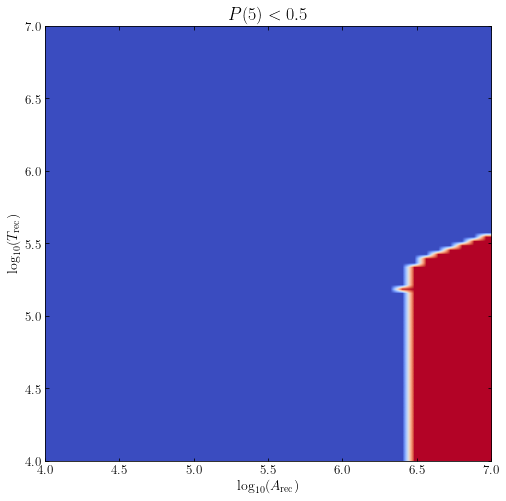

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(limit_grid, cmap='coolwarm', extent=[-1, 7, 4, 7], aspect='auto', interpolation='bilinear')
plt.xlim(4,7)
plt.ylim(4,7)
plt.xlabel('$\log_{10}(A_\mathrm{rec})$')
plt.ylabel('$\log_{10}(T_\mathrm{rec})$')
plt.title('$P({}) < {}$'.format(k_crit, crit_val))
# plt.savefig('Figures/recoupling_constraint.pdf')
plt.show()

In [127]:
path = "observation_data/"

dfDES = pd.read_csv(path + "DESY1.csv")
dfDES = dfDES.assign(
    ylow=dfDES["Y"] - dfDES["-DeltaY"], yhigh=dfDES["+DeltaY"] - dfDES["Y"]
)
dfDES = dfDES.assign(
    xlow=dfDES["X"] - dfDES["-DeltaX"], xhigh=dfDES["+DeltaX"] - dfDES["X"]
)
yerrDES = np.array([dfDES["ylow"], dfDES["yhigh"]])
xerrDES = np.array([dfDES["xlow"], dfDES["xhigh"]])

columns = ["k", "P(k)", "delta P(k)+", "delta P(k)-"]
dfBOSS = pd.read_csv(path + "BOSS.csv", header=None)
dfBOSS.columns = columns

dfBOSS = dfBOSS.assign(
    ylow=dfBOSS["P(k)"] - dfBOSS["delta P(k)-"],
    yhigh=dfBOSS["delta P(k)+"] - dfBOSS["P(k)"],
)
yerrBOSS = np.array([dfBOSS["ylow"], dfBOSS["yhigh"]])


In [128]:
#sort all relevant data by ks
constraint_ks = np.concatenate((dfBOSS["k"], dfDES["X"]))
constraint_pks = np.concatenate((dfBOSS["P(k)"], dfDES["Y"]))
constraint_pk_y_errs = np.concatenate((yerrBOSS, yerrDES), axis=1)
constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]
constraint_pk_y_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_errs_sorted[0] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[0]))]
constraint_pk_y_errs_sorted[1] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[1]))]
constraint_pk_y_var_sorted = constraint_pk_y_errs_sorted[0] + constraint_pk_y_errs_sorted[1]

constraint_ks_sorted = constraint_ks_sorted[14:]
constraint_pks_sorted = constraint_pks_sorted[14:]
constraint_pk_y_var_sorted = constraint_pk_y_var_sorted[14:]

In [132]:
Tr1 = T_rec_strong_arr[40]
Ar1 = A_rec_strong_arr[99]
test_pks = np.zeros(len(constraint_ks_sorted))
for i, k in enumerate(constraint_ks_sorted):
    # test_pks[i] = pk_strong_interp((Tr1, Ar1, k))
    test_pks[i] = pk_strong_interp_late((Tr1, Ar1, k))


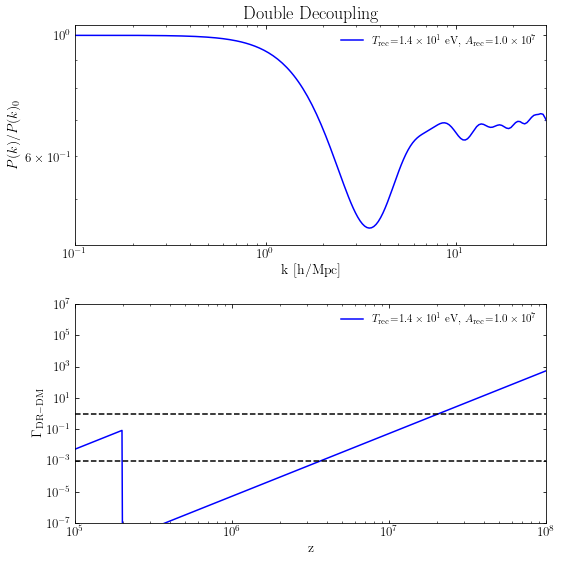

In [198]:
plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False)


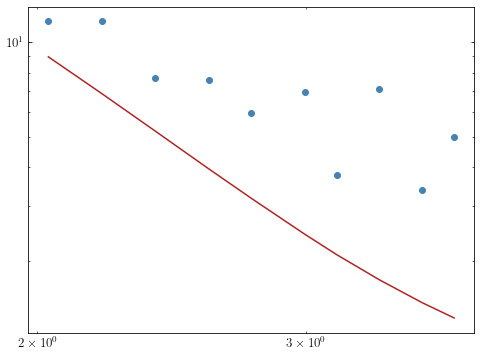

In [199]:
plt.loglog(constraint_ks_sorted, constraint_pks_sorted, 'o')
plt.loglog(constraint_ks_sorted, test_pks)
plt.show()

In [201]:
chi2 = np.sum((constraint_pks_sorted - test_pks)**2 / constraint_pk_y_var_sorted**2)
print(chi2)

2.3016453899095852


In [137]:
def make_constraint_chisquare():
    chi2_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            # test_pks = np.array([pk_strong_interp((Tr, Ar, k)) for k in constraint_ks_sorted])
            test_pks = np.array([pk_strong_interp_late((Tr, Ar, k)) for k in constraint_ks_sorted])

            chi2 = np.sum((constraint_pks_sorted - test_pks)**2 / constraint_pk_y_var_sorted**2)
            chi2_grid[i, j] = chi2
    return chi2_grid

def make_constraint_grid_chisquare(chi2_grid, crit_val = 36.42):
    #crit_val = 36.42 #for 24 points
    limit_grid = np.zeros((N_points, N_points))
    for i in range(N_points):
        for j in range(N_points):
            if chi2_grid[i, j] > crit_val:
                limit_grid[i, j] = 1
    return limit_grid


In [183]:
chi2_grid = make_constraint_chisquare()

In [193]:
limit_grid_chi2 = make_constraint_grid_chisquare(chi2_grid, crit_val = 1)
#! This critical chi2 value is artificially low. Otherwise, don't get any limits

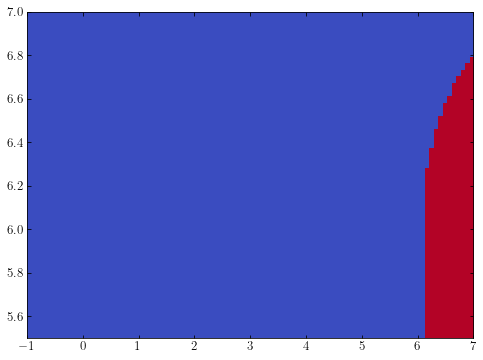

In [194]:
plt.imshow(limit_grid_chi2, cmap='coolwarm', extent=[-1, 7, 4, 7], aspect='auto', interpolation='nearest')
plt.ylim(5.5,7)
plt.show()

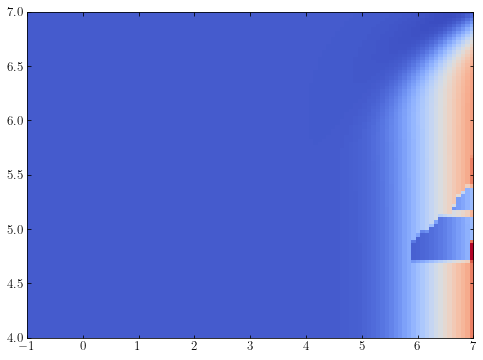

In [195]:
plt.imshow(chi2_grid, cmap='coolwarm', extent=[-1, 7, 4, 7], aspect='auto', interpolation='nearest', norm=LogNorm(vmin=np.min(chi2_grid), vmax=np.max(chi2_grid)))
plt.show()

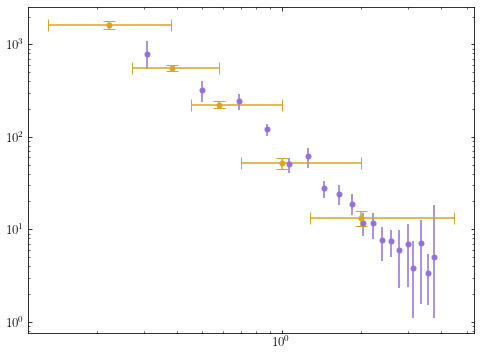

In [205]:
plt.errorbar(
    dfBOSS["k"],
    dfBOSS["P(k)"],
    yerr=yerrBOSS,
    marker="o",
    ms=5,
    color="mediumpurple",
    ls="none",
    label=r"BOSS DR9 Ly-$\alpha$ forest",
)
plt.errorbar(
    dfDES["X"],
    dfDES["Y"],
    yerr=yerrDES,
    xerr=xerrDES,
    marker="o",
    ms=5,
    color="goldenrod",
    ls="none",
    capsize=6,
    label="DES Y1 cosmic Shear",
)

# plt.plot(constraint_ks_sorted, constraint_pks_sorted, color="black", label="Constraint")
# plt.errorbar(constraint_ks_sorted, constraint_pks_sorted, yerr=constraint_pk_y_errs_sorted, color="black", ls="none", alpha=0.5)

plt.xscale("log")
plt.yscale("log")